#### Aug. 12, 2018 2pm

In [1]:
import numpy   as np
import pandas  as pd

import pickle
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve


---

#### Function Definitions

In [2]:
def time_Now():
    import datetime
    import pytz
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    return (pst_now)

In [33]:
import itertools 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)
        
    plt.tight_layout()
    plt.ylabel('True label',  fontsize=14)
    plt.xlabel('Predicted label',  fontsize=14)

In [4]:
def plot_model_ROC(model, X_df, y_true, figTitle=None, printMetrics=False, figName=None):
    '''
        Function will plot the Model's ROC curve with several options:
        - alter the fig TITLE
        - APPEND model metrics to the figure
        - SAVE figure as a *.png and a*.pdf file
        
        Function will execute with only 3 of the 6 parameters
        - sklearn model that can give a predict_proba
        - X_df to apply the predict_proba
        - y_true the true values to compute TPR and FPR (T/F positive rates)
    '''
    
    pred = model.predict(X_df)
    y_score = model.predict_proba(X_df)[:,1]

    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, 'o--')
    plt.plot(np.linspace(0,1), np.linspace(0,1), 'k--')
    plt.ylabel("True Positive Rate",  fontsize=14)
    plt.xlabel("False Positive Rate", fontsize=14);
    plt.text(.6, .1, "AUC score: {0:.4f}".format( roc_auc_score(y_test, y_score) ), fontsize=14);
    
    if figTitle:
        plt.title(figTitle)
    else:
        plt.title(str(model))
        
    if printMetrics:
        plt.text(.6, .15, "Accuracy score: {0:.4f}".format( accuracy_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .2, "Precision score: {0:.4f}".format( precision_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .25, "Recall score: {0:.4f}".format( recall_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .3, "F1 score: {0:.4f}".format( f1_score(y_true, pred) ), fontsize=14);

    if figName:
        print("saving..." + figName)
        plt.gcf()
        plt.savefig(figName + '.png')
        plt.savefig(figName + '.pdf')

In [5]:
def show_most_informative_features(vectorizer, clf, n=20):
    
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [6]:
def topWords(clf_model_nb, vectorFts, numFtrs=50):

    
    # Empirical log probability of features x_i, given a class y; P(x_i|y).

    ftr_logProb = clf_model_nb.feature_log_prob_
    ftr_logProb.shape

    # Smoothed empirical log probability for each class.
    class_logProb = clf_model_nb.class_log_prior_


    posterior_ratios = (ftr_logProb[1,:] - ftr_logProb[0,:] + class_logProb[1] - class_logProb[0])

    inds = np.argsort(posterior_ratios)[-1:-200:-1]

    # posterior_ratios[inds]

    print(np.array(vectorFts)[inds])

---
### Modified: 

In [7]:
print("Last modified on: ", time_Now())

Last modified on:  2018-08-15 09:40:49.055831-07:00


---

### Large Pickled Dataset



In [8]:
%%time
df = pd.read_pickle("newRev_VegCols_US.pkl")

CPU times: user 800 ms, sys: 532 ms, total: 1.33 s
Wall time: 1.33 s


In [9]:
%%time
X_df = df.drop(['vegFriendly', 'Vegan', 'Vegetarian'], axis=1)
y_df = df['vegFriendly']

CPU times: user 96 ms, sys: 32 ms, total: 128 ms
Wall time: 129 ms


In [10]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923002 entries, 0 to 923001
Data columns (total 17 columns):
business_id    923002 non-null object
name           923002 non-null object
review_id      923002 non-null object
stars          923002 non-null int64
date           923002 non-null datetime64[ns]
text           923002 non-null object
useful         923002 non-null int64
funny          923002 non-null int64
cool           923002 non-null int64
city           923002 non-null object
state          923002 non-null object
Thai           923002 non-null float64
Italian        923002 non-null float64
Indian         923002 non-null float64
Chinese        923002 non-null float64
Mexican        923002 non-null float64
Text_length    923002 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(5), object(6)
memory usage: 119.7+ MB


In [11]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: re.sub(r'(\d+)', '', rev) )

CPU times: user 16.2 s, sys: 124 ms, total: 16.3 s
Wall time: 16.3 s


In [12]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: rev.replace('_', '') )

CPU times: user 688 ms, sys: 0 ns, total: 688 ms
Wall time: 685 ms


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=62)

In [14]:
print( X_train.shape, X_test.shape)

(646101, 17) (276901, 17)


---

### Manipulate data sets

In [15]:
stopWords = list(stopwords.words('english'))
stopWords.extend(['good', 'excellent', 'best', 'like', 'place', 'really', 'ordered', 'amazing', 'fantastic', 'am', 'pm'])
# 189 words with the 'eng' set
stopWords.extend(['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuggggggggggggggggggg', 'aaaaaaah'])
stopWords.extend(['aaaaaaamazing', 'aaaaaaand', 'aaaaaamazing', 'aaaaahhhh', 'aaaaahhhhhhmazing', 'aaaaahhhhmaaazeballs', 'aaaaamazing', 'aaaaand'])
stopWords.extend(['aaaack', 'aaaamazing', 'aaaammmazziiigggg', 'aaaand', 'aaaarrgh', 'aaah', 'aaahh'])
stopWords.extend(['aaahhhh', 'aaahhhhh', 'aaahhhhmmmaaazzziiiinnnnggg'])
stopWords.extend(['aaammaziiiing', 'aaand', 'aab', 'aaboud', 'aac', 'aachi', 'aadd', 'aaggh', 'aagh', 'aah', 'aahan', 'aahc', 'aahhh'])
stopWords.extend(['aahhhh', 'aahhhhhh', 'aahhhhhhmazing', 'aahhhhhmazing', 'aahhhhmazing', 'aahing', 'aahran'])
# 234 words with the 'eng' set
stopWords.extend(['aaaaaaaaaa', 'aaaaaaaaaaaaaand', 'aaaaaaaaaaaaaauthentic', 'aaaaaaaaaaaaaawwwwwwwwwwwwwwwwwwwwww', 'aaaaaaaaaaack', 'aaaaaaaaaaah', 'aaaaaaaaaand', 'aaaaaaaaargh', 'aaaaaaaack', 'aaaaaaaahhhhhhhhh', 'aaaaaaaamazing', 'aaaaaaaand', 'aaaaaaall', 'aaaaaaamaaaaazing', 'aaaaaaammmmazing', 'aaaaaahhhh', 'aaaaaahhhhh', 'aaaaaahhhhhmazing', 'aaaaaand', 'aaaaaannnddd', 'aaaaaannnndddd', 'aaaaagh', 'aaaaah', 'aaaaahhhhmazing', 'aaaaamaaazing', 'aaaaammmaazzzinnngg', 'aaaaarrrggghh', 'aaaaawful', 'aaaaay', 'aaaagh', 'aaaah', 'aaaahh', 'aaaahhh', 'aaaahhhh', 'aaaahhhhhhh', 'aaaahmazzzing', 'aaaajúa', 'aaaall', 'aaaalllllllll', 'aaaallright', 'aaaammaaazzinnnggg', 'aaaammazzing', 'aaaammmaaaaazzzziiiinnnngggg', 'aaaammmaaazing', 'aaaammmmmmazing', 'aaaamzing', 'aaaandd', 'aaaanddd', 'aaaannnd', 'aaaannnnd', 'aaaanyway', 'aaaawesoooome', 'aaaawwwesome', 'aaaawwwww', 'aaagggrrrrrrrhhhhh', 'aaahahaa', 'aaahhh', 'aaahhhhhhh', 'aaahhhs', 'aaahing', 'aaahmaaaazing', 'aaahmazing', 'aaahs', 'aaaiiiiight', 'aaall', 'aaallll', 'aaalways', 'aaamaazing', 'aaamazing', 'aaammaaazzziinnnngggg', 'aaammazing', 'aaammmazing', 'aaammmazinggggg', 'aaammmmaaazzziinnggg', 'aaannd', 'aaanndd', 'aaannndd', 'aaannnnd', 'aaanyway', 'aaare', 'aaawwee', 'aaawww', 'aaawwwwsome', 'aaay', 'aacross', 'aadbcc', 'aadorbsssssss', 'aagain', 'aahaan', 'aahed', 'aahh', 'aahs', 'aaid', 'aaiight', 'aaiiight', 'aaim', 'aaka', 'aaked', 'aaliyah', 'aall'])
stopWords.extend(['aaaaaaaaaaaaahhhhhhh', 'aaaaaaaaaah', 'aaaaaaaahhhhmazing', 'aaaaaaaawesooooooooooooome', 'aaaaaaggghhh', 'aaaaaah', 'aaaaaawesome', 'aaaaahhh', 'aaaaahhhhhh', 'aaaahhhhhhs', 'aaaajua', 'aaaalmost', 'aaaamazzzzing', 'aaaammaaazzziiingggg', 'aaaarreeeee', 'aaagh', 'aaahed', 'aaahhhmaaaazing', 'aaahhhmazing', 'aaammaazzing', 'aaarghhh', 'aahaha', 'aahhhhhaaaahhhhh'])
# 357 words with the 'eng' set

In [16]:
vectorizer = CountVectorizer(stop_words=stopWords, strip_accents = 'ascii' )

#### Vectorize Review Text

In [17]:
%%time
X_train_term  = vectorizer.fit_transform(X_train['text'])

CPU times: user 49.2 s, sys: 576 ms, total: 49.8 s
Wall time: 49.8 s


In [18]:
X_train_term.shape

(646101, 137644)

In [19]:
ftrs = vectorizer.get_feature_names()

In [20]:
len(vectorizer.get_stop_words())

357

---

#### Mutlinomial NB - Train

In [21]:
%%time
M_NB_model = MultinomialNB()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15.5 µs


In [22]:
%%time
M_NB_model.fit(X_train_term, y_train)

CPU times: user 352 ms, sys: 68 ms, total: 420 ms
Wall time: 419 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

---

#### Multinomial NB - Test

In [23]:
%%time
X_test_term = vectorizer.transform(X_test['text'])

CPU times: user 20.6 s, sys: 76 ms, total: 20.7 s
Wall time: 20.6 s


In [24]:
X_test_term.shape

(276901, 137644)

In [25]:
%%time
pred = M_NB_model.predict(X_test_term)

CPU times: user 96 ms, sys: 12 ms, total: 108 ms
Wall time: 106 ms


In [26]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

        0.0       0.90      0.91      0.91    220211
        1.0       0.65      0.61      0.63     56690

avg / total       0.85      0.85      0.85    276901



In [27]:
accuracy_score(y_test, pred)

0.8515787230815346

In [28]:
precision_score(y_test, pred)

0.6452905438145291

In [29]:
recall_score(y_test, pred)

0.6107779149761863

In [30]:
f1_score(y_test, pred)

0.6275600826476239

In [35]:
lbls = ['Non-vegFriendly', 'vegFriendly']
cm = confusion_matrix(y_test, pred)

Confusion matrix, without normalization
saving...MNB_357Stw_full_1pgr


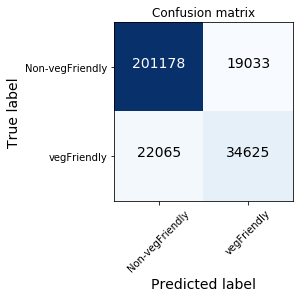

In [36]:
plot_confusion_matrix(cm,lbls)
figName = 'MNB_357Stw_full_1pgr'
# print("saving..." + figName)
# plt.gcf()
# plt.savefig(figName + '.png')
# plt.savefig(figName + '.pdf')

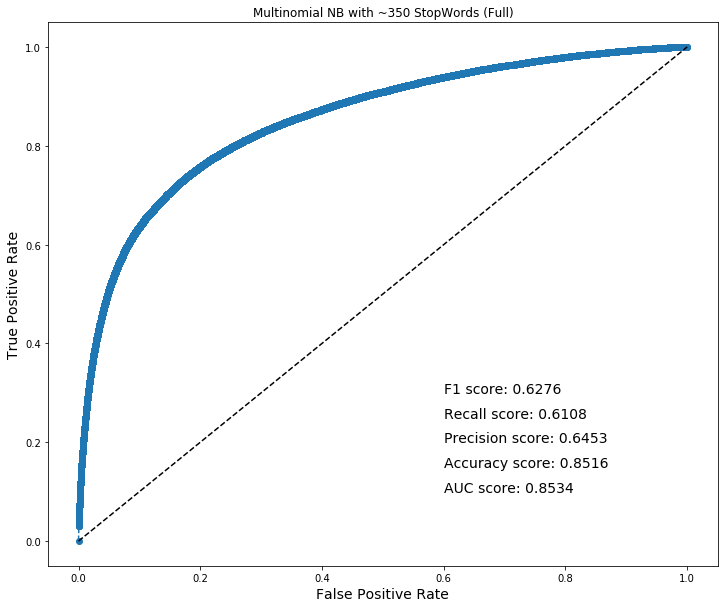

In [32]:
fTitle = 'Multinomial NB with ~350 StopWords (Full)'
mMetrics = True
fName = 'MNB_357StWds_full_countV'
plot_model_ROC(M_NB_model, X_test_term, y_test, fTitle, mMetrics)#, fName)

---

### Log odds of priors

In [33]:
show_most_informative_features(vectorizer, M_NB_model, 20)

	-15.7105	14             		-4.0107	food           
	-15.7105	TM             		-4.6553	great          
	-15.7105	aaaaaaahhhhhh  		-4.9457	service        
	-15.7105	aaaamaaazing   		-5.1159	one            
	-15.7105	aaaayway       		-5.1306	time           
	-15.7105	aakowa         		-5.1555	back           
	-15.7105	aalad          		-5.1945	go             
	-15.7105	aalmon         		-5.2389	chicken        
	-15.7105	aalo           		-5.2397	get            
	-15.7105	aalways        		-5.2947	would          
	-15.7105	aalyssa        		-5.3323	also           
	-15.7105	aamaaazing     		-5.3356	restaurant     
	-15.7105	aamaazingly    		-5.3512	delicious      
	-15.7105	aamco          		-5.4212	love           
	-15.7105	aamsotto       		-5.4334	menu           
	-15.7105	aamzing        		-5.4398	vegan          
	-15.7105	aandwiches     		-5.4578	try            
	-15.7105	aangekleed     		-5.5492	order          
	-15.7105	aangenaam      		-5.6044	got            
	-15.7105	aanji          		-5.6

---
### Ratio of posteriors for both classes

In [34]:
topWords(M_NB_model, ftrs, 50)

['injera' 'wac' 'vegenation' 'tsoynami' 'tsoynamis' 'lalibela' 'vegeway'
 'gomen' 'grabbagreen' 'soynami' 'lunasagna' 'chopt' 'nami' 'wellness'
 'brimstone' 'tfk' 'chakra' 'capastrami' 'tibs' 'eatt' 'brizza' 'pastoli'
 'alicha' 'misir' 'moko' 'chima' 'yayo' 'mijana' 'violette' 'doan' 'tlt'
 'thailicious' 'choolaah' 'tsom' 'taytu' 'cinnaholic' 'pitza' 'apteka'
 'dotty' 'ethiopian' 'zizi' 'grabba' 'doro' 'lgbtq' 'hussong' 'abay' 'ycs'
 'olivier' 'misoya' 'teff' 'yc' 'mvpita' 'yinzburgh' 'fosolia' 'quesas'
 'tikil' 'adda' 'wheatgrass' 'rvc' 'merkato' 'fern' 'fuegos' 'kome'
 'soynamis' 'graz' 'zoma' 'rawco' 'sambusas' 'mika' 'ipho' 'berbere'
 'aladdins' 'sega' 'braggs' 'chikn' 'panevino' 'buraka' 'sonio' 'ganoosh'
 'hemp' 'ikes' 'naji' 'kinoko' 'tofurky' 'treehouse' 'capistrami'
 'sprinly' 'nandini' 'sambussa' 'kitfo' 'jovany' 'nekter' 'gandhi'
 'kyklos' 'omnis' 'pastolis' 'greene' 'dumplinghaus' 'zenith' 'condesa'
 'angara' 'yalla' 'ethiopians' 'mestizo' 'maca' 'shawerma' 'dobra'
 'chopsh